## 필수과제1
- 모델을 단순하게 RandomForest만 학습
- 타이타닉 데이터를 RF모델을 튜닝하여 과적합을 최소화 하여 하이퍼 파라미터를 찾고, 해당 하이퍼파라미터를 가지고 다시 한 번 샤플리를 진행해서
- 기존 베이스 모델의 샤플리값과 과적합을 최소화한 모델의 하이퍼파라미터로 샤플리값을 추출하는 것
- 둘을 비교해 주시면 됩니다.
    - **필수적으로**
    - 과적합을 최소화했다는 기준
        - 성능?
        - 그리드 서치 등을 통해 찾은 것인지?
        - 시각화 등으로도 보여주면서 과적합을 최소화 했다는 것을 코드와 함께 설명해 주셔야 합니다.

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

In [253]:
df = sns.load_dataset('titanic')
df['sex'] =df['sex'].map({'male':0,'female':1})

X= df[['sex','age','fare','pclass']]
y= df['survived']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

### 기존 모델

In [256]:
rf_clf = RandomForestClassifier(random_state=1, n_jobs=-1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [257]:
y_pred = rf_clf.predict(X_test)

print('파라미터:',rf_clf.get_params())
print('정확도: {0:.4f}'.format(accuracy_score(y_test, y_pred)))

파라미터: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}
정확도: 0.7799


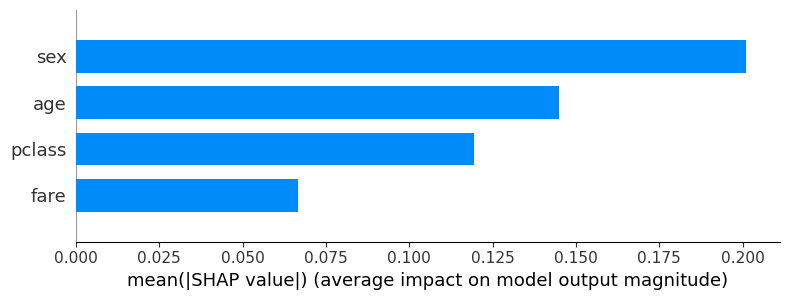

In [260]:
sh = shap.TreeExplainer(rf_clf)
shap_values = sh.shap_values(X_test)
shap.summary_plot(shap_values[:,:,0],  plot_type='bar', feature_names= X_test.columns.tolist())

### 과적합 최소화 모델

In [262]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [100,300,500],
         'max_depth' : [None, 5, 10],
         'min_samples_split' : [4, 6, 8],
         'min_samples_leaf' : [1, 2, 3]}

rf_clf = RandomForestClassifier(random_state=1, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [100, 300, 500]})

In [264]:
print('파라미터:',grid_cv.best_params_)
print('정확도: {0:.4f}'.format(grid_cv.best_score_))

파라미터: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300}
정확도: 0.8523


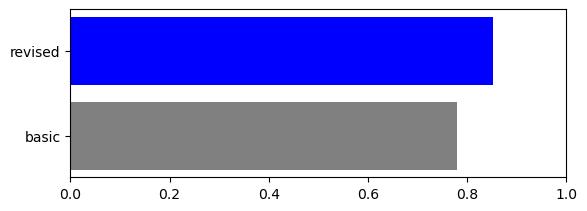

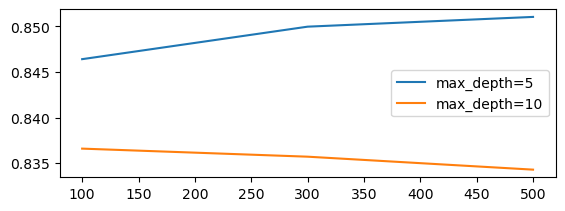

In [265]:
plt.subplot(2,1,1)
plt.barh(['basic', 'revised'], [accuracy_score(y_test, y_pred), grid_cv.best_score_], color=['grey', 'blue'])
plt.xlim(0, 1)
plt.show()

cv_results = pd.DataFrame(grid_cv.cv_results_)
mean_test_scores = cv_results.pivot_table(
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators"
)

plt.subplot(2,1,2)
for max_depth in mean_test_scores.index:
    plt.plot(mean_test_scores.columns, mean_test_scores.loc[max_depth], label=f'max_depth={max_depth}')
plt.legend()
plt.show()

- Grid Search를 통해, 기존 모델보다 과적합을 최소화함
- n_estimator 값이 커지고, max_depth 값이 작아질수록 성능이 개선됨을 확인 

In [267]:
rf_clf_rvs = RandomForestClassifier(random_state=1, n_jobs=-1, max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=300)
rf_clf_rvs.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=8, n_estimators=300,
                       n_jobs=-1, random_state=1)

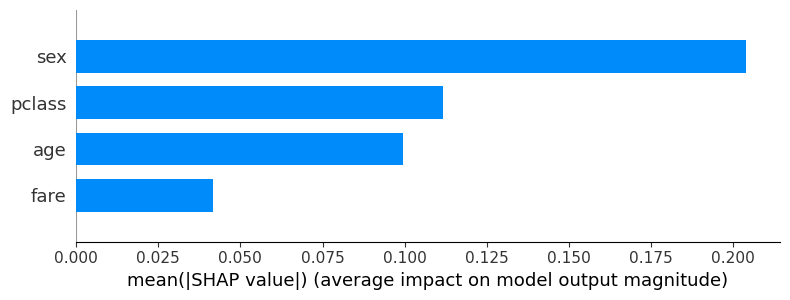

In [268]:
sh = shap.TreeExplainer(rf_clf_rvs)
shap_values_rvs = sh.shap_values(X_test)
shap.summary_plot(shap_values_rvs[:,:,0],  plot_type='bar', feature_names= X_test.columns.tolist())

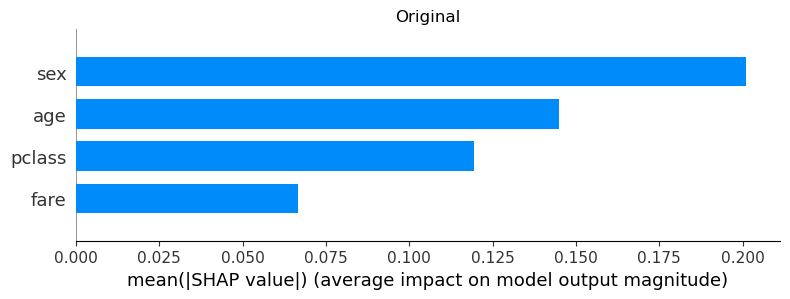

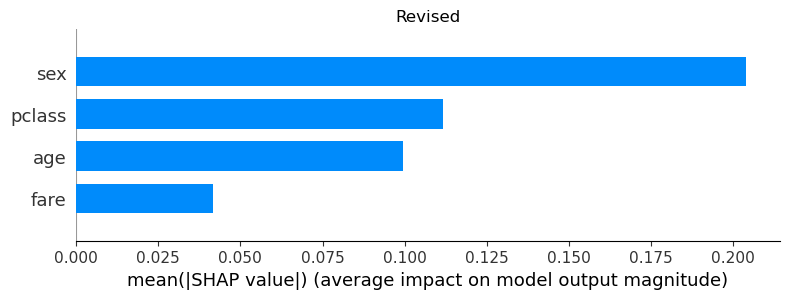

In [278]:
plt.title('Original')
shap.summary_plot(shap_values[:,:,0],  plot_type='bar', feature_names= X_test.columns.tolist())

plt.title('Revised')
shap.summary_plot(shap_values_rvs[:,:,0],  plot_type='bar', feature_names= X_test.columns.tolist())

- 두 모형 모두 가장 중요한 특성은 'sex' 였고 비슷한 중요도를 보인다
- 원본 모형에서는 'age'가 다음 중요 속성였으나, 과적합 조정 후에는 'pclass'가 다음 중요 속성으로 나타났다.
- 과적합 조정 후, 'sex' 를 제외하고 모든 속성은 중요도가 감소한 모습이 나타났다. 